In this notebook, I am using the Fitbit Kaggle dataset and load it to my personal Bigquery in order to make the data cleaning process. 

I could use plain python/pandas code, but I want to show what I can do with SQL and BigQuery. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/minuteCaloriesNarrow_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyIntensities_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/minuteIntensitiesWide_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/minuteMETsNarrow_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyCalories_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlyCalories_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/minuteSleep_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlyIntensities_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlySteps_merged.csv
/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/minuteStepsNarro

## Loading the kaggle dataset to Bigquery

This step is not needed, since I could clean and analyze the dataset in python, but I want to play with the new tools that I learned. Therefore I will upload the kaggle dataset into my personal Google Cloud Services (GCS) area. 

Reminder: link your Kaggle notebook to Google Cloud Services in the menu `Add-ons > Google Cloud Services`.

I have a test project in my GCS area called `test-project-306614` where I will upload the datasets. 

In [2]:
from google.cloud import bigquery

projectID = 'test-project-306614'
datasetID = 'Fitabase'
# Construct a BigQuery client object.
client = bigquery.Client(project=projectID, location='US')  ## not sure if the location is needed
# client.create_dataset(datasetID)  ## to run only one time to create the dataset

The next cell creates tables in the `datasetID`. It should be run only once. 

In [3]:
from google.api_core.exceptions import AlreadyExists, Conflict

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         tableName = filename.replace('_merged.csv','')
#         try: client.create_table(f"{projectID}.{datasetID}.{tableName}")
#         except Conflict: print(f'Table {tableName} already created')
        
#         datasetRef = client.dataset(datasetID)
#         tableRef = datasetRef.table(tableName)
#         jobConfig = bigquery.LoadJobConfig()
        
#         #### the fitbit dataset contains date columns using am/pm format, which BigQuery 
#         #### has problems identifying. I am using a quick hack using pandas here.
#         tmpDf = pd.read_csv(os.path.join(dirname, filename))
#         for iCol in tmpDf.columns.to_list():
#             if iCol.endswith(('Minute', 'Hour', 'date', 'Time', 'Date', 'Day')): 
#                 tmpDf[iCol] = pd.to_datetime(tmpDf[iCol])
#         job = client.load_table_from_dataframe(tmpDf, tableRef, job_config=jobConfig)
#         job.result()
        
#         print("Loaded {} rows into {}:{}.".format(job.output_rows, datasetID, tableName))

After creating the dataset in BigQuery, let's load the datasets for cleaning.

In [4]:
dataset = client.get_dataset(datasetID)   
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset
for table in tables: print(table.table_id)

dailyActivity
dailyCalories
dailyIntensities
dailySteps
heartrate_seconds
hourlyCalories
hourlyIntensities
hourlySteps
minuteCaloriesNarrow
minuteCaloriesWide
minuteIntensitiesNarrow
minuteIntensitiesWide
minuteMETsNarrow
minuteSleep
minuteStepsNarrow
minuteStepsWide
sleepDay
weightLogInfo


Simple test to see if the queries are working:

In [5]:
query = f""" SELECT *
        FROM `{projectID}.{datasetID}.dailyActivity`"""

# Set up the query
query_job = client.query(query)

# API request - run the query, and return a pandas DataFrame
data = query_job.to_dataframe()
data.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1624580081,2016-05-01 00:00:00+00:00,36019,28.030001,28.030001,0.0,21.92,4.19,1.91,0.02,186,63,171,1020,2690
1,1644430081,2016-04-14 00:00:00+00:00,11037,8.020000,8.020000,0.0,0.36,2.56,5.10,0.00,5,58,252,1125,3226
2,1644430081,2016-04-19 00:00:00+00:00,11256,8.180000,8.180000,0.0,0.36,2.53,5.30,0.00,5,58,278,1099,3300
3,1644430081,2016-04-28 00:00:00+00:00,9405,6.840000,6.840000,0.0,0.20,2.32,4.31,0.00,3,53,227,1157,3108
4,1644430081,2016-04-30 00:00:00+00:00,18213,13.240000,13.240000,0.0,0.63,3.14,9.46,0.00,9,71,402,816,3846


Checking the number of dates per Id.

In [6]:
query = f""" 
SELECT 
    CAST(Id AS INT) AS newId,
    COUNT(ActivityDate) as count
FROM `{projectID}.{datasetID}.dailyActivity`
GROUP BY newId
ORDER BY count ASC
"""

query_job = client.query(query)
data = query_job.to_dataframe()
data

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,newId,count
0,4057192912,4
1,2347167796,18
2,8253242879,19
3,3372868164,20
4,6775888955,26
5,7007744171,26
6,6117666160,28
7,8792009665,29
8,6290855005,29
9,1644430081,30


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


<AxesSubplot:xlabel='Date', ylabel='newId'>

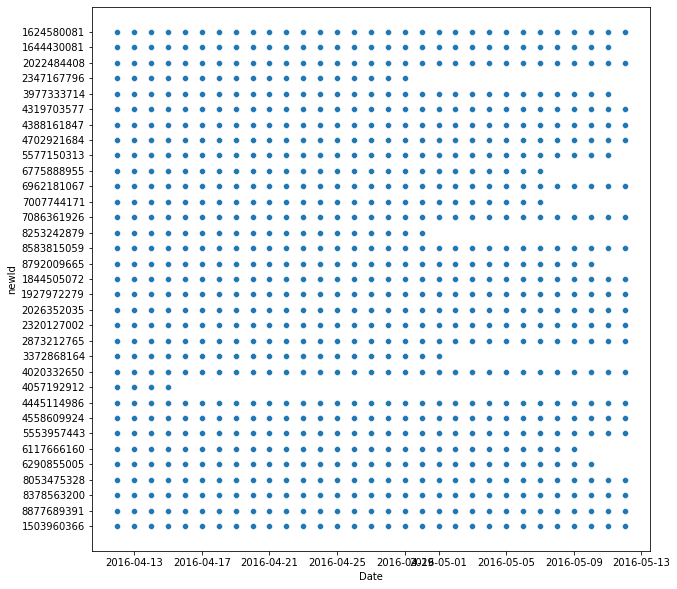

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt 

query = f""" 
SELECT 
    CAST(Id AS STRING) AS newId, 
    CAST(ActivityDate AS DATE) AS Date
FROM `{projectID}.{datasetID}.dailyActivity`
"""
query_job = client.query(query)
data = query_job.to_dataframe()
plt.figure(figsize=(10,10))
sns.scatterplot(data=data, x='Date', y='newId' )

Let's create tables without the ids 4057192912, 2347167796, 8253242879, 3372868164, and according to the plot above between `2016-04-12` and `2016-05-07` where all the participants have data.

In [8]:
# from google.api_core.exceptions import AlreadyExists, Conflict

# for table in tables: 
#     print('Processing table: ', table.table_id)
#     tableName = table.table_id+'_cleaned'
#         try: client.create_table(f"{projectID}.{datasetID}.{tableName}")
#         except Conflict: print(f'Table {tableName} already created')
        
#         datasetRef = client.dataset(datasetID)
#         tableRef = datasetRef.table(tableName)
#         jobConfig = bigquery.LoadJobConfig()
        
#         query = f""" 
# SELECT * 
# FROM `{projectID}.{datasetID}.{table.table_id}`
# WHERE ActivityDa
# """
# query_job = client.query(query)
# data = query_job.to_dataframe()
        
# #         #### the fitbit dataset contains date columns using am/pm format, which BigQuery 
# #         #### has problems identifying. I am using a quick hack using pandas here.
# #         tmpDf = pd.read_csv(os.path.join(dirname, filename))
# #         for iCol in tmpDf.columns.to_list():
# #             if iCol.endswith(('Minute', 'Hour', 'date', 'Time', 'Date', 'Day')): 
# #                 tmpDf[iCol] = pd.to_datetime(tmpDf[iCol])
# #         job = client.load_table_from_dataframe(tmpDf, tableRef, job_config=jobConfig)
# #         job.result()
        
# #         print("Loaded {} rows into {}:{}.".format(job.output_rows, datasetID, tableName))

Checking if the tables have `nan` values in there

In [9]:
for table in tables: 
    print('Checking table: ', table.table_id)
    query = f"""
SELECT col_name, COUNT(1) AS null_count
FROM `{projectID}.{datasetID}.{table.table_id}` AS t,
UNNEST(REGEXP_EXTRACT_ALL(TO_JSON_STRING(t), r'"(\w+)":null')) col_name
GROUP BY col_name
"""

    query_job = client.query(query)
    data = query_job.to_dataframe()
    display(data)

Checking table:  dailyActivity


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  dailyCalories


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  dailyIntensities


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  dailySteps


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  heartrate_seconds


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  hourlyCalories


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  hourlyIntensities


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  hourlySteps


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  minuteCaloriesNarrow


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  minuteCaloriesWide


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  minuteIntensitiesNarrow


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  minuteIntensitiesWide


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  minuteMETsNarrow


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  minuteSleep


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  minuteStepsNarrow


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  minuteStepsWide


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  sleepDay


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count


Checking table:  weightLogInfo


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,col_name,null_count
0,Fat,65


In [10]:
query = f""" 
SELECT *
FROM `{projectID}.{datasetID}.weightLogInfo`
WHERE Fat > 0
"""

query_job = client.query(query)
data = query_job.to_dataframe()
data

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,4319703577,2016-04-17 23:59:59+00:00,72.400002,159.614681,25.0,27.450001,True,1460937599000
1,1503960366,2016-05-02 23:59:59+00:00,52.599998,115.963147,22.0,22.650000,True,1462233599000


Checking if there are duplicate rows in tables:

In [11]:
for table in tables: 
    print('Checking table: ', table.table_id)
    query = f""" 
SELECT
    (SELECT COUNT(1) FROM (SELECT DISTINCT * FROM `{projectID}.{datasetID}.{table.table_id}`)) AS distinct_rows,
    (SELECT COUNT(1) FROM `{projectID}.{datasetID}.{table.table_id}`) AS total_rows
"""
    query_job = client.query(query)
    data = query_job.to_dataframe()
    display(data)

Checking table:  dailyActivity


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,940,940


Checking table:  dailyCalories


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,940,940


Checking table:  dailyIntensities


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,940,940


Checking table:  dailySteps


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,940,940


Checking table:  heartrate_seconds


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,2483658,2483658


Checking table:  hourlyCalories


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,22099,22099


Checking table:  hourlyIntensities


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,22099,22099


Checking table:  hourlySteps


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,22099,22099


Checking table:  minuteCaloriesNarrow


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,1325580,1325580


Checking table:  minuteCaloriesWide


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,21645,21645


Checking table:  minuteIntensitiesNarrow


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,1325580,1325580


Checking table:  minuteIntensitiesWide


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,21645,21645


Checking table:  minuteMETsNarrow


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,1325580,1325580


Checking table:  minuteSleep


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,187978,188521


Checking table:  minuteStepsNarrow


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,1325580,1325580


Checking table:  minuteStepsWide


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,21645,21645


Checking table:  sleepDay


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,410,413


Checking table:  weightLogInfo


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,distinct_rows,total_rows
0,67,67


Finally, just for fun, I merged all the daily information into one `csv` file.

In [12]:
query = f"""
WITH dailyActivity AS (
    SELECT 
        dailyActivity.*,
        dailySleep.* EXCEPT( Id, SleepDay )
    FROM `{projectID}.{datasetID}.dailyActivity` AS dailyActivity
    LEFT JOIN `{projectID}.{datasetID}.sleepDay` AS dailySleep 
        ON dailyActivity.Id = dailySleep.Id AND CAST( dailyActivity.ActivityDate as dateTime ) = CAST( dailySleep.SleepDay as dateTime )
)
SELECT 
    dailyActivity.*,
    dailyWeight.* EXCEPT(Id, Date)
FROM dailyActivity
LEFT JOIN `{projectID}.{datasetID}.weightLogInfo` AS dailyWeight 
    ON dailyActivity.Id = dailyWeight.Id AND CAST( dailyActivity.ActivityDate as dateTime ) = CAST( dailyWeight.Date as dateTime )
#GROUP BY Id
"""

# Set up the query
query_job = client.query(query)

# API request - run the query, and return a pandas DataFrame
data = query_job.to_dataframe()
data.to_csv('dailyActivity_allmerged.csv', index=False )
data.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,...,Calories,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1624580081,2016-05-01 00:00:00+00:00,36019,28.030001,28.030001,0.0,21.92,4.19,1.91,0.02,...,2690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
1,1644430081,2016-04-14 00:00:00+00:00,11037,8.020000,8.020000,0.0,0.36,2.56,5.10,0.00,...,3226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
2,1644430081,2016-04-19 00:00:00+00:00,11256,8.180000,8.180000,0.0,0.36,2.53,5.30,0.00,...,3300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,1644430081,2016-04-28 00:00:00+00:00,9405,6.840000,6.840000,0.0,0.20,2.32,4.31,0.00,...,3108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
4,1644430081,2016-04-30 00:00:00+00:00,18213,13.240000,13.240000,0.0,0.63,3.14,9.46,0.00,...,3846,1.0,124.0,142.0,NaN,NaN,NaN,NaN,None,NaN
